In [1]:

from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import DynUNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import json
from datetime import datetime
from data_preparation2 import DataHandling 
from UNet_model import create_unet
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    SpatialPadd, ScaleIntensityd, CenterSpatialCropd
)

import math


In [2]:
data_dir = '/homes/zshahpouri/DLP/ASC-PET-TEST'
directory = '/homes/zshahpouri/DLP/Practic/LOGTEST'
output_dir = '/homes/zshahpouri/DLP/Practic/OUT'

In [3]:

train_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(data_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]


# Calculate split sizes
total_size = len(data_dicts)
train_size = math.floor(total_size * 0.7)
val_size = math.floor(total_size * 0.2)
# The test set gets the remaining data points
test_size = total_size - train_size - val_size

# Split the dataset
train_files = data_dicts[:train_size]
val_files = data_dicts[train_size:(train_size + val_size)]
test_files = data_dicts[(train_size + val_size):]


In [4]:
print(len(test_files))
print(len(val_files))
print(len(train_files))


6
11
39


In [5]:
roi_size = [168, 168, 32]

train_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
        
        SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Pad to ensure minimum size
        
        RandCropByPosNegLabeld(
            keys=["image", "target"],
            label_key="target",
            spatial_size=(168, 168, 32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),        ])

val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
        SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["image", "target"], roi_size=(168, 168, 320)),  # Ensure uniform size
    ])

test_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        # Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
        SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["image", "target"], roi_size=(168, 168, 320)),  # Ensure uniform size
    ])


train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=8)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=8)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=8)

test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=8)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8)


Loading dataset:   0%|          | 0/39 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


image shape: torch.Size([168, 168, 320]), target shape: torch.Size([168, 168, 320])


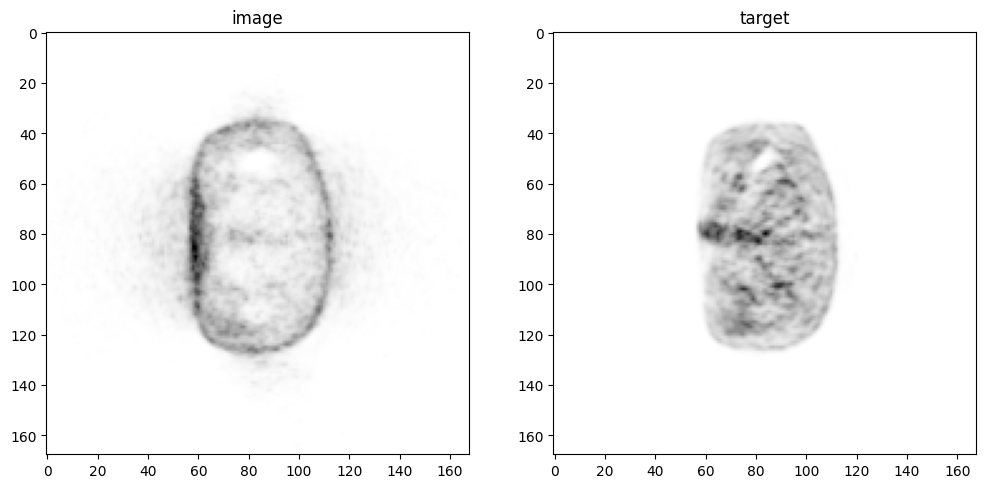

In [5]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 50

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="gist_yarg")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n],cmap='gist_yarg' )
plt.show()

In [6]:
import os
import datetime
from datetime import datetime


class TrainingLogger:
    def __init__(self, directory):
        self.directory = directory
        self.ensure_directory_exists(self.directory)
        self.log_file = self.create_log_file()

    def ensure_directory_exists(self, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def create_log_file(self):
        filename = f"{self.directory}/log_{self.get_date()}.txt"
        return open(filename, "w")

    def get_date(self):

        s = datetime.now()
        date = f"{s.month}_{s.day}_{s.hour}_{s.minute}"
        return date

    def log(self, message):
        print(message)
        self.log_file.write(message + "\n")

    def close(self):
        self.log_file.close()

In [7]:
starting_epoch = 0
decay_epoch = 5
learning_rate = 0.001

import torch
from monai.networks.nets import DynUNet
from torch import nn

class DecayLR:
    def __init__(self, epochs, offset, decay_epochs):
        epoch_flag = epochs - decay_epochs
        assert (epoch_flag > 0), "Decay must start before the training session ends!"
        self.epochs = epochs
        self.offset = offset
        self.decay_epochs = decay_epochs

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_epochs) / (self.epochs - self.decay_epochs)
    


In [9]:
from monai.apps.reconstruction.networks.nets.coil_sensitivity_model import CoilSensitivityModel
from monai.apps.reconstruction.networks.nets.varnet import VariationalNetworkModel
from monai.apps.reconstruction.networks.nets.complex_unet import ComplexUnet


sensitivity_model_features =[8, 16, 32, 64, 128, 8] # type=list, help="six integers as numbers of sensitivity model features (see monai.networks.nets.basic_unet)",
features =[18, 36, 72, 144, 288, 18] # type=list, help="six integers as numbers of features (see monai.networks.nets.basic_unet)",
num_cascades = 12

    # create the model
coil_sens_model = CoilSensitivityModel(spatial_dims=2, features=sensitivity_model_features)
refinement_model = ComplexUnet(spatial_dims=2, features=features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VariationalNetworkModel(coil_sens_model, refinement_model, num_cascades=num_cascades).to(device)
print("#model_params:", np.sum([len(p.flatten()) for p in model.parameters()]))



BasicUNet features: (8, 16, 32, 64, 128, 8).
BasicUNet features: (18, 36, 72, 144, 288, 18).
#model_params: 30069558


In [10]:
loss_function = torch.nn.MSELoss()

print('Defining optimizer...')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

max_epochs = 10
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
train_losses = []
val_losses = []

# Define scheduler
print('Defining scheduler...')
lr_lambda = DecayLR(epochs=max_epochs, offset=0, decay_epochs=decay_epoch).step
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

Defining optimizer...
Defining scheduler...


In [11]:


class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, optimizer, loss_function, scheduler, max_epochs, val_interval, directory, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.scheduler = scheduler  # Add scheduler to the class initialization
        self.max_epochs = max_epochs
        self.val_interval = val_interval
        self.directory = directory
        self.device = device  # Assuming device is passed as a parameter
        self.logger = TrainingLogger(directory)
        self.best_metric = float('inf')
        self.best_metric_epoch = -1


    def log(self):
        self.logger.log(f"train set: {len(train_files)}" )
        self.logger.log(f"validation set: {len(val_files)}")
        self.logger.log(f"max_epochs: {max_epochs}")
        self.logger.log(f"val_interval: {val_interval}")
        # self.logger.log(f"model.channels: {model.channels}")



    def train(self):
        for epoch in range(self.max_epochs):
            self.logger.log("-" * 10)
            self.logger.log(f"epoch {epoch + 1}/{self.max_epochs}")

            self.model.train()
            epoch_loss = 0
            step = 0

            for batch_data in self.train_loader:
                step += 1
                inputs, targets = batch_data["image"].to(self.device), batch_data["target"].to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.loss_function(outputs, targets)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                self.logger.log(f"{step}/{len(self.train_loader.dataset) // self.train_loader.batch_size}, train_loss: {loss.item():.4f}")

            epoch_loss /= step
            self.logger.log(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            # Step the scheduler here, after the training phase and before the validation phase
            self.scheduler.step()
            self.logger.log(f"Stepped scheduler to epoch {epoch + 1}, current lr: {self.scheduler.get_last_lr()}")

            # Validation logic remains largely the same
            if (epoch + 1) % self.val_interval == 0:
                self.model.eval()
                val_loss = 0
                roi_size = (168, 168, 32)
                sw_batch_size = 16
                
                with torch.no_grad():
                    for val_data in self.val_loader:
                        val_inputs, val_targets = val_data["image"].to(self.device), val_data["target"].to(self.device)

                        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                        val_loss += self.loss_function(val_outputs, val_targets).item()

                val_loss /= len(self.val_loader)
                self.logger.log(f"Validation loss: {val_loss:.4f}")

                if val_loss < self.best_metric:
                    self.best_metric = val_loss
                    self.best_metric_epoch = epoch + 1
                    self.save_model()

        self.logger.close()

    def save_model(self):
        model_filename = f"model_{self.logger.get_date()}.pth"
        torch.save(self.model.state_dict(), os.path.join(self.directory, model_filename))
        self.logger.log(f"Saved {model_filename} model, best_metric: {self.best_metric:.4f}, epoch: {self.best_metric_epoch}")


    
trainer = ModelTrainer(model, train_loader, val_loader, optimizer, loss_function, scheduler, max_epochs, val_interval,directory, device)
trainer.log()
trainer.train()

train set: 39
validation set: 11
max_epochs: 10
val_interval: 2
----------
epoch 1/10


TypeError: VariationalNetworkModel.forward() missing 1 required positional argument: 'mask'

In [9]:
def find_last_saved_model(log_filepath):
    last_saved_model = None
    best_metric = None
    epoch = None
    with open(log_filepath, 'r') as file:
        for line in file:
            if "Saved" in line and ".pth" in line:
                parts = line.split(',')
                last_saved_model = parts[0].split()[1]  # Extract model filename
                best_metric = float(parts[1].split(': ')[1])  # Extract best metric
                epoch = int(parts[2].split(': ')[1])  # Extract epoch number
    return last_saved_model, best_metric, epoch


log_filename = 'log_2_19_8_7.txt'
log_filepath = directory + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_2_20_10_22.pth, Best Metric: 0.1283, Epoch: 252


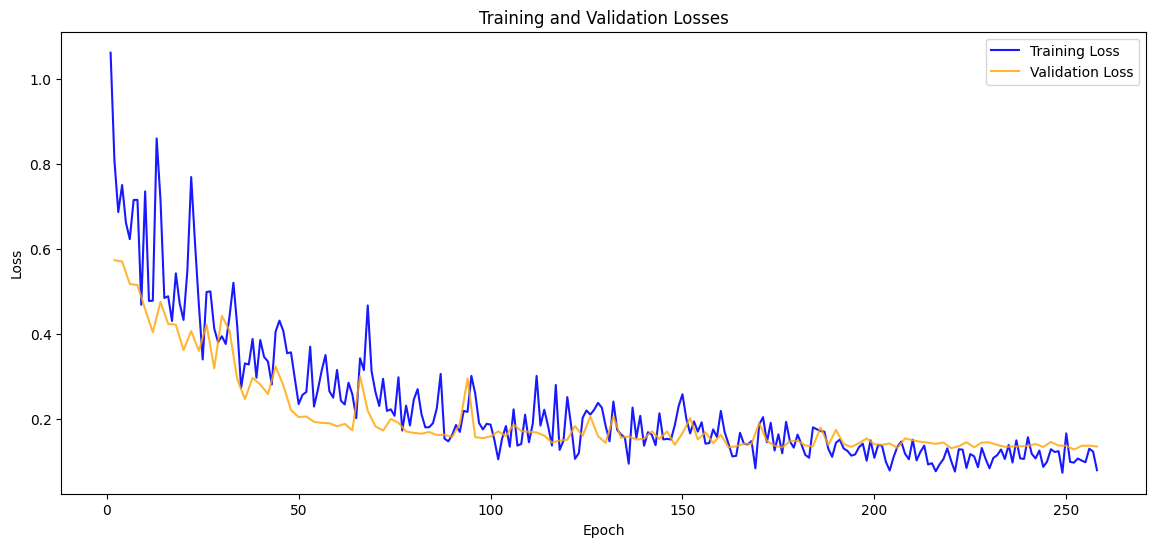

In [15]:
# Function to parse the loss values from the log file
def parse_loss_values(log_filepath):
    train_losses = []
    val_losses = []
    with open(log_filepath, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses


train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Filter data starting from epoch 50
start_epoch = 1
train_losses_filtered = train_losses[start_epoch - 1:]
val_losses_filtered = val_losses[(start_epoch - 1) // val_interval:][:len(train_losses_filtered)]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(start_epoch, start_epoch + len(train_losses_filtered)), train_losses_filtered, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(start_epoch + 1, start_epoch + len(train_losses_filtered) + 1, val_interval), val_losses_filtered, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.show()


ValueError: x and y must have same first dimension, but have shapes (258,) and (209,)

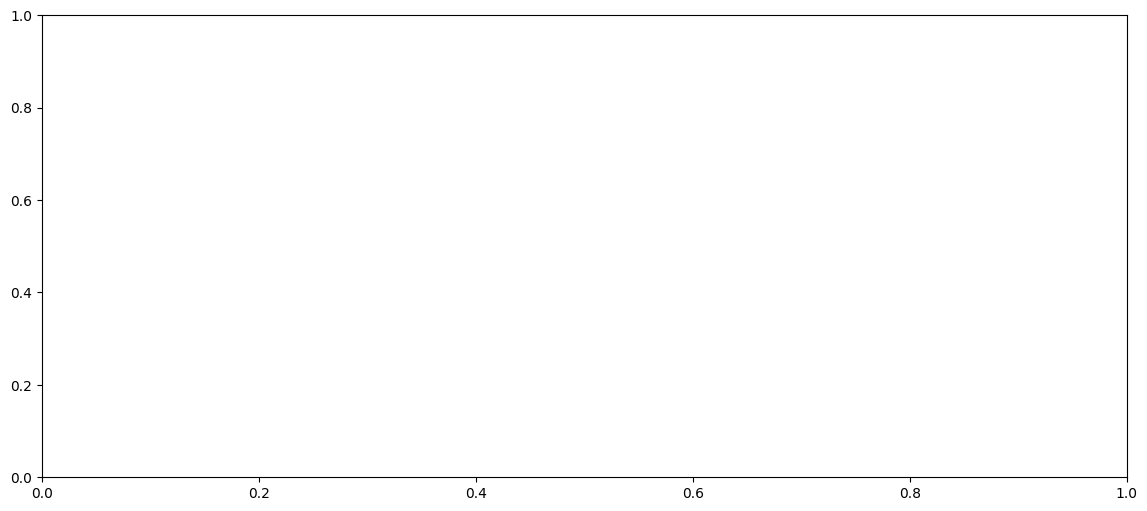

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming parse_loss_values function is defined and works correctly
# and log_filepath is defined and points to your log file
train_losses, val_losses = parse_loss_values(log_filepath)

# Validation interval
val_interval = 2 

# Start epoch is the epoch from which you want to start plotting
start_epoch = 50

# Assuming start_epoch, train_losses, and val_losses are already defined

# Calculate the number of validation epochs
num_val_epochs = len(val_losses) * val_interval

# Create arrays for the x-axis (epochs) and (validation epochs)
epochs = range(start_epoch, start_epoch + len(train_losses))
val_epochs = range(start_epoch, start_epoch + num_val_epochs, val_interval)

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(epochs, train_losses[start_epoch-1:], label='Training Loss', color='blue', alpha=0.9)
plt.plot(val_epochs, val_losses[(start_epoch-1)//val_interval:], label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()



In [17]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(directory, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

Model file model_2_20_10_22.pth is loading.


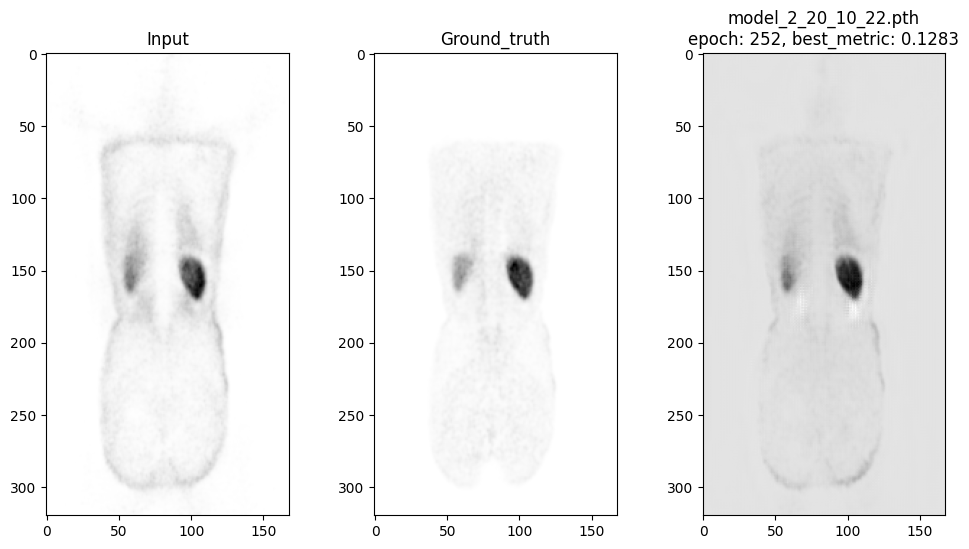

In [18]:
def visualize_results_whole(data, model, n, title):
    model.eval()
    with torch.no_grad():
        model_outputs = model(data["image"].to(device))

    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(data["image"][0, 0, :, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"Ground_truth")
    target_slice = np.rot90(data["target"][0, 0, :, n, :])
    plt.imshow(target_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(model_outputs.detach().cpu()[0, 0, :, n, :])
    plt.imshow(output_slice, cmap="gist_yarg")
    
    plt.show()

# Usage
with torch.no_grad():
    for i, data in enumerate(val_loader):
        n = 100
        visualize_results_whole(data, model, n, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}")
        if i == 0:
            break


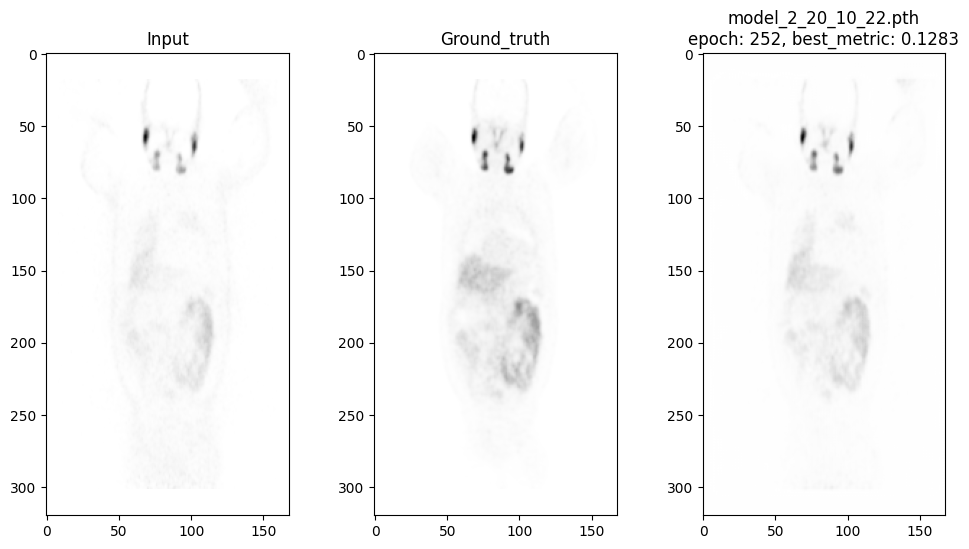

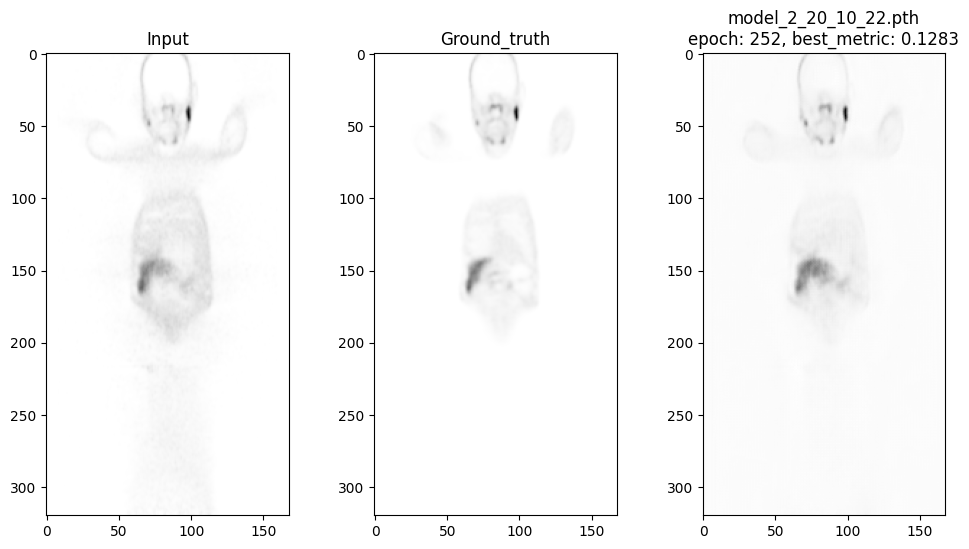

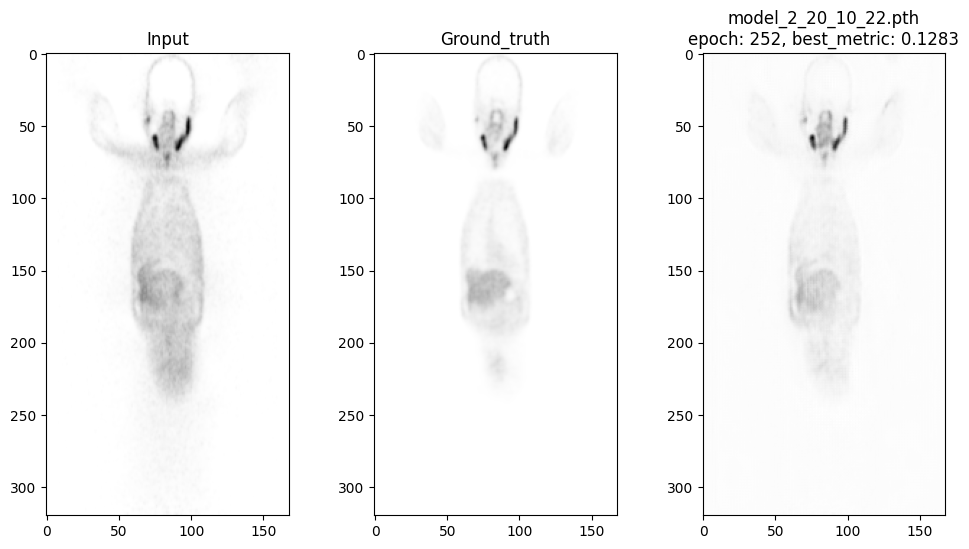

In [19]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        n = 70
        visualize_results_whole(data, model, n, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}")
        if i == 2:
            break

100%|██████████| 2/2 [00:37<00:00, 18.84s/it]


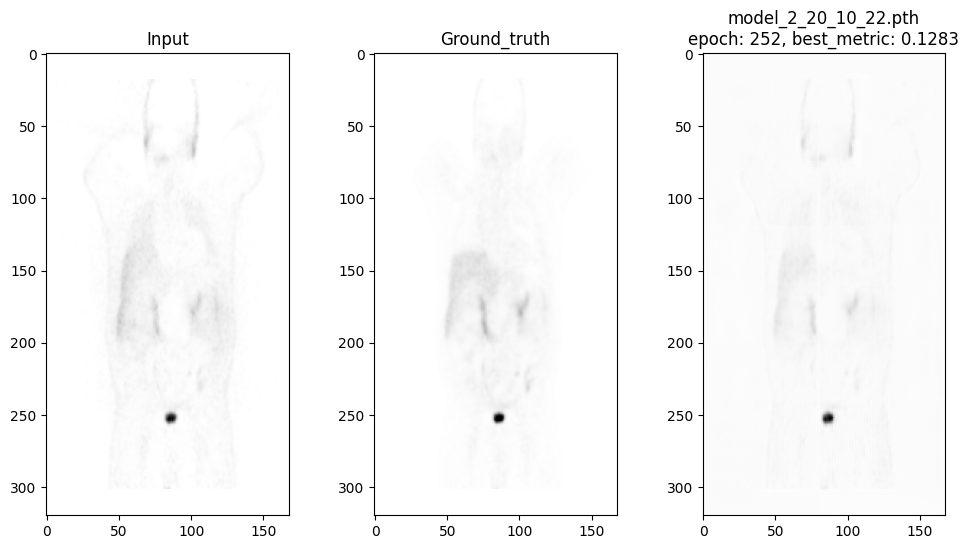

100%|██████████| 2/2 [00:36<00:00, 18.44s/it]


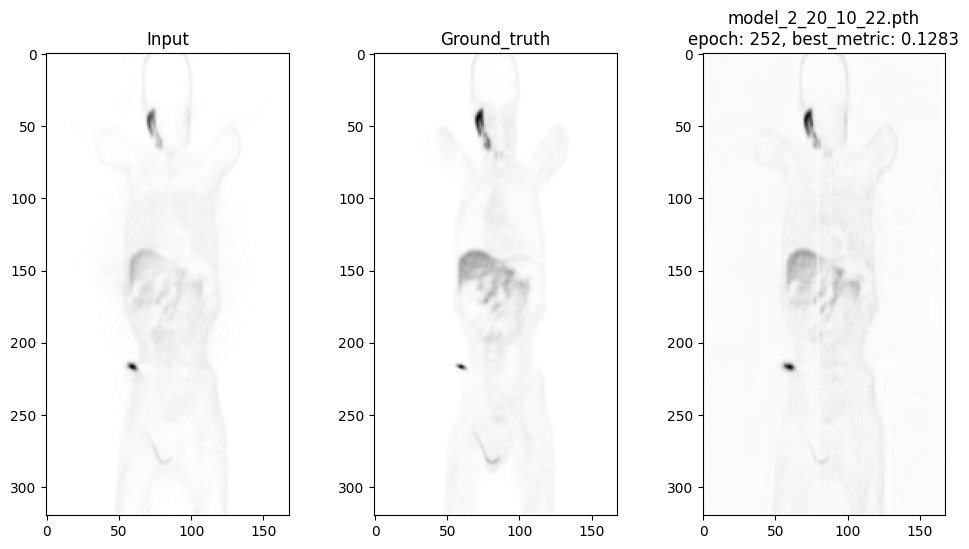

100%|██████████| 2/2 [00:40<00:00, 20.00s/it]


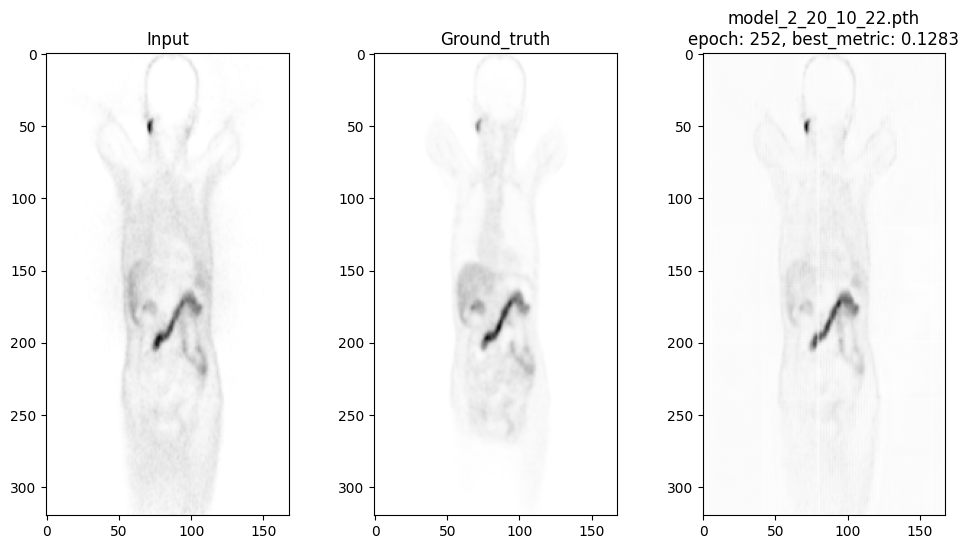

In [21]:
# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.50) # using ov= 0.9 best image ever I have.


    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(val_data["image"][0, 0, :, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"Ground_truth")
    target_slice = np.rot90(val_data["target"][0, 0, :, n, :])
    plt.imshow(target_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(val_outputs.detach().cpu()[0, 0, :, n, :])
    plt.imshow(output_slice, cmap="gist_yarg")
    
    plt.show()


roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, val_data in enumerate(test_loader):

        n = 80
        visualize_results(val_data, model, n, f"{bestmodel_filename}\nepoch: { best_epoch}, best_metric: {best_metric}")
        if i == 2:
            break




----------
# Export

In [ ]:
from utils import get_nifti_header, save_output_with_affine
import nibabel as nib
import torch

In [23]:
# Extract file names
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]

from monai.transforms import Invertd, SaveImaged, Compose, LoadImaged, EnsureChannelFirstd
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch

test_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
    ]
)

test_org_ds = Dataset(data=test_files, transform=test_org_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="DLdyn2", resample=False),
    ]
)
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 64
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.70)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]


2024-02-21 07:52:12,909 INFO image_writer.py:197 - writing: out/004230_C4_SH_/004230_C4_SH__DLdyn2.nii.gz


KeyboardInterrupt: 